# Análise da Rentabilidade de Fundos

### Inicializações

In [20]:
import pandas as pd
from datetime import datetime
import math
import matplotlib.pyplot as plt
import seaborn as sn

encoding='latin_1'
thousands = ','
decimal = '.'
to_date = lambda d: datetime.strptime(d, '%d-%m-%Y').date()
transacoes_csv = 'transacoes.csv'
cotacoes_xls = 'historico_cotacoes.xlsx'

In [21]:
#Get the Exchange Rates
exchange_rates_csv = 'exchange_rates.csv'
exchange_rates = pd.read_csv(exchange_rates_csv ,sep=';',parse_dates=[0])
exchange_rates['Date'] = exchange_rates['Date'].apply(lambda x: x.date())
exchange_rates = exchange_rates.set_index('Date')['USD2EUR']
exchange_rates.head()

Date
2023-09-08    0.93398
2023-09-07    0.93458
2023-09-06    0.93225
2023-09-05    0.93229
2023-09-04    0.92635
Name: USD2EUR, dtype: float64

### Obter informação de cotações

In [22]:
#Read XLS
dict_df = pd.read_excel(cotacoes_xls,sheet_name=None)

# Parse the date and set it as index
for key in dict_df.keys():
    dict_df[key]['Date'] = dict_df[key].apply(lambda x: pd.to_datetime(x['Date'], infer_datetime_format = True).date(), axis=1)
    dict_df[key].set_index('Date',drop=True, inplace=True)

# Create the DataFrame from the Dictionary of Dataframes, removing rows with null values
df_cotacoes = pd.concat([dict_df[f_name][['Close']].rename(columns={'Close':f_name}) for f_name in dict_df.keys()],axis=1).sort_index(ascending=False).fillna(method='bfill').fillna(method='pad')

df_cotacoes.head()


,LU0094557526,LU0248173006,PTSQUGHM0007,LU0384381660,LU1769942746,LU0108459040,LU1670715975,IE00BLP5S460,LU0269905138,LU0524465977,...,LU0213962813,LU0266117414,LU0300742037,LU0332193340,LU0425092995,LU0985320646,LU1278917452,LU1670718219,LU2295319565,LU0941349275
Date,,,,,,,,,,,,,,,,,,,,,
2023-09-08,45.74,37.47,11.08,63.52,317.66,758.71,45.00,1.44,16.26,239.29,...,50.47,78.53,6.87,1006.97,28.45,172.03,239.43,10.72,14.14,113.26
2023-09-07,45.63,37.57,11.08,63.03,315.69,758.71,45.57,1.44,16.28,239.29,...,50.15,77.08,6.83,999.44,28.71,171.82,240.18,10.71,13.93,113.26
2023-09-06,45.69,37.95,11.08,63.09,317.87,759.27,45.66,1.44,16.50,240.93,...,49.22,79.34,6.86,998.76,28.75,172.42,244.15,10.71,14.30,113.29
2023-09-05,46.02,38.20,11.08,63.80,321.02,762.69,45.55,1.43,16.69,242.62,...,49.61,78.28,6.89,999.89,28.61,173.25,243.86,10.71,14.09,113.69
2023-09-04,46.32,38.30,11.08,64.21,321.67,771.34,45.46,1.43,16.86,242.55,...,48.74,78.62,6.85,986.27,28.57,173.17,240.39,10.72,14.07,113.95


In [23]:
df_cotacoes

,LU0094557526,LU0248173006,PTSQUGHM0007,LU0384381660,LU1769942746,LU0108459040,LU1670715975,IE00BLP5S460,LU0269905138,LU0524465977,...,LU0213962813,LU0266117414,LU0300742037,LU0332193340,LU0425092995,LU0985320646,LU1278917452,LU1670718219,LU2295319565,LU0941349275
Date,,,,,,,,,,,,,,,,,,,,,
2023-09-08,45.74,37.47,11.08,63.52,317.66,758.71,45.00,1.44,16.26,239.29,...,50.47,78.53,6.87,1006.97,28.45,172.03,239.43,10.72,14.14,113.26
2023-09-07,45.63,37.57,11.08,63.03,315.69,758.71,45.57,1.44,16.28,239.29,...,50.15,77.08,6.83,999.44,28.71,171.82,240.18,10.71,13.93,113.26
2023-09-06,45.69,37.95,11.08,63.09,317.87,759.27,45.66,1.44,16.50,240.93,...,49.22,79.34,6.86,998.76,28.75,172.42,244.15,10.71,14.30,113.29
2023-09-05,46.02,38.20,11.08,63.80,321.02,762.69,45.55,1.43,16.69,242.62,...,49.61,78.28,6.89,999.89,28.61,173.25,243.86,10.71,14.09,113.69
2023-09-04,46.32,38.30,11.08,64.21,321.67,771.34,45.46,1.43,16.86,242.55,...,48.74,78.62,6.85,986.27,28.57,173.17,240.39,10.72,14.07,113.95
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-07,46.63,46.39,10.17,69.89,297.16,823.21,42.15,1.23,21.65,216.13,...,28.60,77.80,6.37,933.24,26.75,172.68,229.83,10.43,14.48,115.29
2021-07-06,46.27,46.16,10.17,69.89,297.16,823.21,42.15,1.23,21.65,216.13,...,28.60,77.80,6.37,933.24,26.75,172.68,229.83,10.43,14.48,115.29
2021-07-05,46.28,46.08,10.17,69.89,297.16,823.21,42.15,1.23,21.65,216.13,...,28.60,77.80,6.37,933.24,26.75,172.68,229.83,10.43,14.48,115.29


### Obter informação de transações

In [24]:
converters={'Data de subscricao': to_date}
df_transacoes = pd.read_csv(transacoes_csv ,sep=',',encoding=encoding,thousands=thousands, decimal=decimal, converters=converters, dtype={'Cotacao de Subscricao':float,'Quantidade':float})
df_transacoes['Data de resgate'] = df_transacoes['Data de resgate'].apply(lambda x: datetime.strptime(x, '%d-%m-%Y').date() if pd.notnull(x) else x)

# Criar Dataframe de Portofolio Actual
df_portofolio = df_transacoes[pd.isnull(df_transacoes['Data de resgate'])].drop(columns=['Data de resgate','Cotacao de resgate']).copy()

i = 0
while df_cotacoes.index[i] > exchange_rates.index[0]:
    exchange_rates[df_cotacoes.index[i]] = exchange_rates[0]
    i += 1
    
last_date = min(df_cotacoes.index[0],exchange_rates.index[0])
# Get the exchange rate for the last date of the historical quotes
usd2eur = exchange_rates.loc[last_date]

df_portofolio['Data da cotacao'] = df_cotacoes.index[0]
df_portofolio['cotacao actual'] = df_portofolio.apply(lambda x: df_cotacoes[x['Code']][0] * (usd2eur if x['Moeda'] == 'USD' else 1), axis=1)
df_portofolio['Dias'] = (df_portofolio['Data da cotacao']-df_portofolio['Data de subscricao']).apply(lambda x: x.days)

# Criar Dataframe com o Historico
df_historico = df_transacoes[pd.notnull(df_transacoes['Data de resgate'])].copy()
df_historico['Dias'] = (df_historico['Data de resgate']-df_historico['Data de subscricao']).apply(lambda x: x.days)
df_historico['Cotacao de resgate'] = df_historico['Cotacao de resgate'].astype(float)

### Cálculo Rentabilidade do Histórico

In [25]:
df_historico['Rentabilidade anual %'] = df_historico.apply(lambda x: 100*(math.pow(x['Cotacao de resgate']/x['Cotacao de Subscricao'],
                                                        float(365.0/x['Dias']))-1), axis=1)
df_historico['Rentabilidade Absoluta'] = df_historico['Cotacao de resgate']*100/df_historico['Cotacao de Subscricao']-100

df_historico['Valor Actual'] = df_historico['Quantidade']*df_historico['Cotacao de resgate']


print("Rentabilidade Absoluta", sum(df_historico['Quantidade']*df_historico['Cotacao de resgate'])*100/sum(df_historico['Quantidade']*df_historico['Cotacao de Subscricao'])-100)

df_historico['Ganho Absoluto'] = df_historico['Quantidade']*(df_historico['Cotacao de resgate']-df_historico['Cotacao de Subscricao'])
print("Ganho Absoluto", sum(df_historico['Ganho Absoluto']),'em', sum(df_historico['Quantidade']*df_historico['Cotacao de Subscricao']))

dias_medio = (df_historico['Quantidade']*df_historico['Cotacao de Subscricao']*df_historico['Dias']).sum() / (df_historico['Quantidade']*df_historico['Cotacao de Subscricao']).sum()
print("Rentabilidade Média Anual", 100*(math.pow(df_historico['Ganho Absoluto'].sum()/sum(df_historico['Quantidade']*df_historico['Cotacao de Subscricao'])+1, float(365.0/dias_medio))-1))


Rentabilidade Absoluta 3.7315976288423798
Ganho Absoluto 16984.108511821752 em 455143.08350256004
Rentabilidade Média Anual 6.35139592856242


In [26]:
df_historico.sort_values(by=['Data de resgate'],ascending=False)

,Code,Nome,Quantidade,Data de subscricao,Cotacao de Subscricao,Moeda,Data de resgate,Cotacao de resgate,Dias,Rentabilidade anual %,Rentabilidade Absoluta,Valor Actual,Ganho Absoluto
53,LU2471777289,BTG Latin American Eq A,20.220,2022-12-06,98.9400,USD,2023-09-05,99.977345,273,1.404256,1.048459,2021.541921,20.975121
52,LU2471777289,BTG Latin American Eq A,11.120,2022-11-08,94.3900,USD,2023-09-05,99.977345,301,7.222528,5.919425,1111.748079,62.131279
17,LU1046234842,Schroder Euro Alpha Ret B,17.380,2023-01-23,86.2953,EUR,2023-09-04,86.697100,224,0.759807,0.465611,1506.795598,6.983284
36,LU0823415012,BNP Energy Transition Cap,3.570,2023-02-06,736.6600,EUR,2023-03-16,619.700000,38,-80.998708,-15.877067,2212.329000,-417.547200
16,LU0088927925,Janus Euro Property A2,40.153,2023-01-18,49.8100,EUR,2023-03-14,43.749907,55,-57.722317,-12.166419,1756.690000,-243.330930
...,...,...,...,...,...,...,...,...,...,...,...,...,...
170,LU0171310955,BGF Wor Techn EUR E,34.520,2017-04-20,19.4400,EUR,2019-06-06,28.970000,777,20.610796,49.022634,1000.044400,328.975600
171,LU0171310955,BGF Wor Techn EUR E,51.780,2017-04-20,19.4400,EUR,2019-06-06,28.970000,777,20.610796,49.022634,1500.066600,493.463400
286,LU0117884675,JPM Europ Dyn Tech,36.101,2016-01-29,9.8200,EUR,2019-06-06,13.850000,1224,10.798292,41.038697,499.998850,145.487030
228,LU1548497772,A Artific Intellig,8.305,2017-07-07,104.0600,EUR,2019-06-05,120.411000,698,7.930468,15.713050,1000.013355,135.795055


### Cálculo Rentabilidade do Portfólio

In [27]:
df_portofolio['Rentabilidade anual %'] = df_portofolio.apply(lambda x: 100*(math.pow(x['cotacao actual']/x['Cotacao de Subscricao'],
                                                        float(365.0/x['Dias']))-1), axis=1)

df_portofolio['Rentabilidade Absoluta'] = df_portofolio['cotacao actual']*100/df_portofolio['Cotacao de Subscricao']-100
df_portofolio['Valor Actual'] = df_portofolio['Quantidade']*df_portofolio['cotacao actual']
print("Rentabilidade Absoluta", sum(df_portofolio['Valor Actual'])*100/sum(df_portofolio['Quantidade']*df_portofolio['Cotacao de Subscricao'])-100)

df_portofolio['Ganho Absoluto'] = df_portofolio['Quantidade']*(df_portofolio['cotacao actual']-df_portofolio['Cotacao de Subscricao'])
print("Ganho Absoluto", sum(df_portofolio['Ganho Absoluto']),'em', sum(df_portofolio['Quantidade']*df_portofolio['Cotacao de Subscricao']),'=', sum(df_portofolio['Valor Actual']))

dias_medio = (df_portofolio['Quantidade']*df_portofolio['Cotacao de Subscricao']*df_portofolio['Dias']).sum() / (df_portofolio['Quantidade']*df_portofolio['Cotacao de Subscricao']).sum()
print("Rentabilidade Média Anual", 100*(math.pow(df_portofolio['Ganho Absoluto'].sum()/sum(df_portofolio['Quantidade']*df_portofolio['Cotacao de Subscricao'])+1, 
                                                 float(365.0/dias_medio))-1))


Rentabilidade Absoluta 1.4846079491629496
Ganho Absoluto 3752.2746680618507 em 252745.15539119169 = 256497.43005925356
Rentabilidade Média Anual 3.585152992401164


### Rentabilidade Global

In [28]:

dias_medio = (df_portofolio['Quantidade']*df_portofolio['Cotacao de Subscricao']*df_portofolio['Dias']).sum() 
dias_medio += (df_historico['Quantidade']*df_historico['Cotacao de Subscricao']*df_historico['Dias']).sum()
dias_medio_div = (df_portofolio['Quantidade']*df_portofolio['Cotacao de Subscricao']).sum() + (df_historico['Quantidade']*df_historico['Cotacao de Subscricao']).sum()
dias_medio = dias_medio / dias_medio_div
ganho = df_portofolio['Ganho Absoluto'].sum() + df_historico['Ganho Absoluto'].sum()
ganho_relativo = ganho / (sum(df_portofolio['Quantidade']*df_portofolio['Cotacao de Subscricao']) + sum(df_historico['Quantidade']*df_historico['Cotacao de Subscricao']))
print("Rentabilidade Média Anual", 100*(math.pow(ganho_relativo+1, float(365.0/dias_medio))-1))


Rentabilidade Média Anual 5.578068161209293


In [29]:
df_portofolio.groupby(by=["Code","Nome"]).sum()[['Quantidade','Valor Actual','Ganho Absoluto']].sort_values(by='Ganho Absoluto', ascending=False)

,,Quantidade,Valor Actual,Ganho Absoluto
Code,Nome,,,
PTSQUGHM0007,Property Core Real Estate,2621.32420,29044.272136,1424.273949
LU1244139660,TRP Glb Technology,242.09000,5073.845976,1103.595977
IE0002167009,JH Glob Tech and Innov A2,250.56600,4783.304940,1083.311160
LU1670707956,M&G (Lux) Europ Strategic Val A,965.57600,10632.560049,1061.470025
LU1670715975,MG Japan SmCap A Eur,159.75100,7188.795000,652.024010
LU1897414303,Janus Biotech A2 USD,175.13000,3377.677494,494.157495
LU0094557526,MFS European Research A1 EUR,196.82900,9002.958460,462.501200
IE00BLP5S460,Jupiter Glb Abs Rt EUR,5007.51100,7210.815840,310.814139
LU0269905138,Schroder Glob Emerg Opp B Accum,368.97000,5603.368366,305.344410


<AxesSubplot:xlabel='Date'>

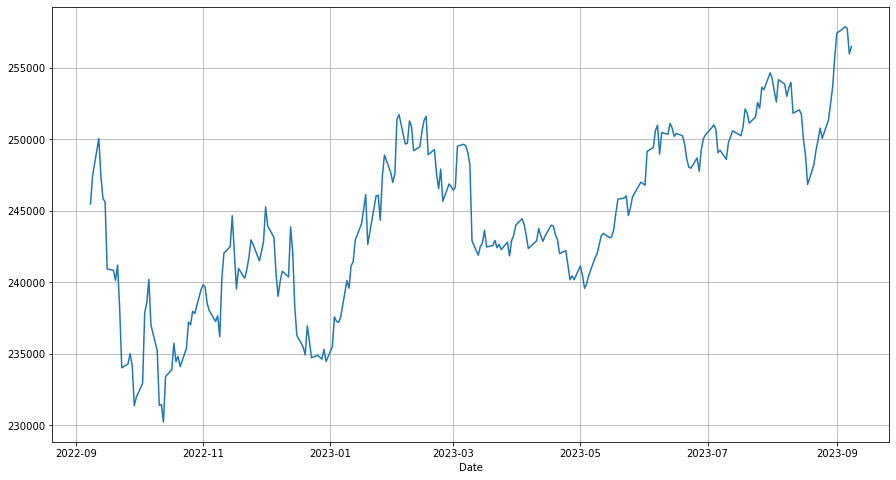

In [30]:
#Get the Portofolio
size=260
portfolio_csv = 'portofolio.csv'
df_meta = pd.read_csv(portfolio_csv ,sep=';').set_index('Code')
df_global = df_cotacoes[:size].apply(lambda x: sum(df_meta['Quantidade'][k]*v*(exchange_rates[x.name] if df_meta['Moeda'][k] == 'USD' else 1) for k,v in x.items()),axis=1)        
df_global[:].plot(figsize=(15,8),grid=True)

In [31]:
start =30
stop = 0
df_global_grow = (df_global / df_global.shift(-1)).dropna()
growth = (df_global.iloc[stop]/df_global.iloc[start]-1)
growth_abs = df_global.iloc[stop] - df_global.iloc[start]
std = df_global_grow.std()
'Growth ABS = {:.2f}, Growth = {:.2%}, STD = {:.6f}, Racio = {:.3f}'.format(growth_abs, growth,std,growth/std)

'Growth ABS = 3036.84, Growth = 1.20%, STD = 0.005803, Racio = 2.065'

# SP 500 Comparision

In [32]:
# https://www.spglobal.com/spdji/en/indices/equity/sp-500/#overview
df_sp500 = pd.read_excel('PerformanceGraphExport.xls', sheet_name="Performance Graph", header=None, names=['Date','Value'], usecols="A:B", skiprows=7).dropna()
ds_sp500 = df_sp500['Value']
ds_sp500.index = df_sp500['Date'].apply(lambda x: x.date())
ds_sp500 = ds_sp500.reindex(pd.date_range(ds_sp500.index.min(),ds_sp500.index.max())).interpolate()
ds_sp500

2013-08-30    1835.31
2013-08-31    1838.26
2013-09-01    1841.21
2013-09-02    1844.16
2013-09-03    1847.11
               ...   
2023-08-28    7349.12
2023-08-29    7439.80
2023-08-30    7401.54
2023-08-31    7442.51
2023-09-01    7488.02
Freq: D, Name: Value, Length: 3655, dtype: float64

In [33]:
df_sp500_hist = df_historico[['Dias']].copy()
df_sp500_hist['Cost'] = df_historico.apply(lambda x: x['Quantidade']*x['Cotacao de Subscricao'],axis=1)
df_sp500_hist['Quantidade'] = df_historico.apply(lambda x: x['Quantidade']*x['Cotacao de Subscricao']/ds_sp500[pd.to_datetime(x['Data de subscricao'])],axis=1)
df_sp500_hist['Net'] = df_sp500_hist['Quantidade']*df_historico.apply(lambda x: (ds_sp500[pd.to_datetime(x['Data de resgate'])]-ds_sp500[pd.to_datetime(x['Data de subscricao'])]),axis=1)
dias_medio = (df_sp500_hist['Cost']*df_sp500_hist['Dias']).sum() / df_sp500_hist['Cost'].sum()
print("SP500 Histórico: Custo={}, Ganho={}".format(df_sp500_hist['Cost'].sum(),df_sp500_hist['Net'].sum()))
print("Rentabilidade SP500 Histórico", 100*(math.pow(df_sp500_hist['Net'].sum()/sum(df_sp500_hist['Cost'])+1, 
                                                 float(365.0/dias_medio))-1))


KeyError: Timestamp('2023-09-04 00:00:00')

In [ ]:
df_sp500_portf = df_portofolio[['Code']].copy()
df_portf_tmp = df_portofolio[df_portofolio['Data de subscricao'].apply(lambda x: pd.to_datetime(x)) <= ds_sp500.index.max()]
df_sp500_portf['Days'] = df_portf_tmp.apply(lambda x: (dict_df[x['Code']].index.max() - x['Data de subscricao']).days, axis=1)
df_sp500_portf['Quantidade'] = df_portf_tmp.apply(lambda x: x['Quantidade']*x['Cotacao de Subscricao']/ds_sp500[pd.to_datetime(x['Data de subscricao'])],axis=1)
df_sp500_portf['Cost'] = df_portf_tmp.apply(lambda x: x['Quantidade']*x['Cotacao de Subscricao'],axis=1)
df_sp500_portf['Net'] = df_sp500_portf['Quantidade']*df_portf_tmp.apply(lambda x: (ds_sp500.loc[ds_sp500.index.max()]-ds_sp500[pd.to_datetime(x['Data de subscricao'])]),axis=1)
dias_medio = (df_sp500_portf['Cost']*df_sp500_portf['Days']).sum() / df_sp500_portf['Cost'].sum()
print("SP500 Portfolio: Custo={}, Ganho={}".format(df_sp500_portf['Cost'].sum(),df_sp500_portf['Net'].sum()))
print("Rentabilidade SP500 Portfolio at {}".format(ds_sp500.index.max()), 100*(math.pow(df_sp500_portf['Net'].sum()/sum(df_sp500_portf['Cost'])+1, 
                                                 float(365.0/dias_medio))-1))

SP500 Portfolio: Custo=127027.03907327887, Ganho=14490.616243621658
Rentabilidade SP500 Portfolio at 2023-09-01 00:00:00 16.65631111039079


<AxesSubplot:>

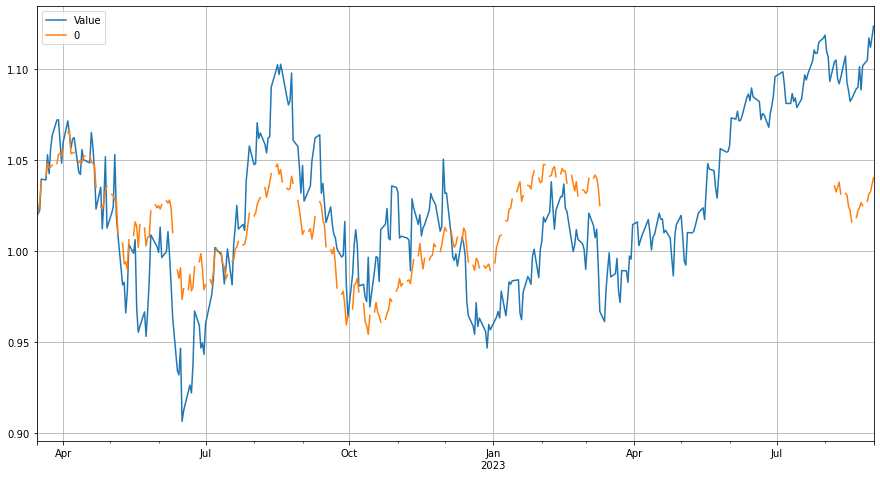

In [ ]:
#Comparision of the current portfolio
n_days = 280
df = df_cotacoes[:n_days].apply(lambda x: sum(df_meta['Quantidade'][k]*v*(exchange_rates[x.name] if df_meta['Moeda'][k] == 'USD' else 1) for k,v in x.items()),axis=1).sort_index()
pd.concat([ds_sp500[df.index.min():].pct_change().cumsum()+1, df.pct_change().cumsum()+1],axis=1).plot(figsize=(15,8),grid=True)

<AxesSubplot:>

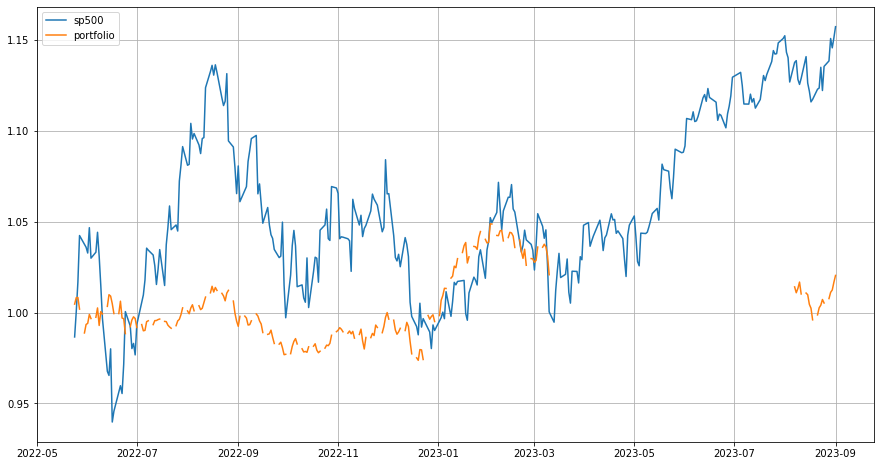

In [ ]:
n_days = 230
df_t = df_transacoes[df_transacoes['Code'].isin(df_cotacoes.columns)].copy()
first_date = max(df_cotacoes.index[n_days],df_t['Data de subscricao'].min())
portf_perform = []
df_tmp = df_t[(df_t['Data de subscricao']<=first_date) & ((pd.isnull(df_t['Data de resgate'])) | (df_t['Data de resgate']>first_date))]
last_val = df_tmp.apply(lambda x: x['Quantidade']*df_cotacoes[x['Code']][first_date] * (exchange_rates.loc[first_date] if x['Moeda'] == 'USD' else 1), axis=1).sum()
for i_date in df_cotacoes[:first_date].index.sort_values()[1:]:
    df_tmp = df_t[(df_t['Data de subscricao']<i_date) & ((pd.isnull(df_t['Data de resgate'])) | (df_t['Data de resgate']>=i_date))]
    new_val = df_tmp.apply(lambda x: x['Quantidade']*df_cotacoes[x['Code']][i_date] * (exchange_rates.loc[i_date] if x['Moeda'] == 'USD' else 1), axis=1).sum()
    portf_perform.append(new_val/last_val-1.0)
    df_tmp = df_t[(df_t['Data de subscricao']<=i_date) & ((pd.isnull(df_t['Data de resgate'])) | (df_t['Data de resgate']>i_date))]
    last_val = df_tmp.apply(lambda x: x['Quantidade']*df_cotacoes[x['Code']][i_date] * (exchange_rates.loc[i_date] if x['Moeda'] == 'USD' else 1), axis=1).sum()
portf_perform = pd.Series(data=portf_perform, index= df_cotacoes[:first_date].index.sort_values()[1:], name="portfolio")

sp500_perform = []
last_val = ds_sp500[pd.to_datetime(first_date)]
for i_date in ds_sp500[pd.to_datetime(first_date):].index[1:]:
    sp500_perform.append(ds_sp500[i_date]/last_val-1.0)
    last_val = ds_sp500[i_date]

sp500_perform = pd.Series(data=sp500_perform, index= [x.date() for x in ds_sp500[pd.to_datetime(first_date):].index[1:]], name="sp500")

pd.concat([sp500_perform.cumsum()+1, portf_perform.cumsum()+1],axis=1).plot(figsize=(15,8),grid=True)


In [ ]:
n_days = 230
df_t = df_transacoes[df_transacoes['Code'].isin(df_cotacoes.columns)].copy()
first_date = max(df_cotacoes.index[n_days],df_t['Data de subscricao'].min())
portf_perform = []
df_tmp = df_t[(df_t['Data de subscricao']<=first_date) & ((pd.isnull(df_t['Data de resgate'])) | (df_t['Data de resgate']>first_date))]
last_val = df_tmp.apply(lambda x: x['Quantidade']*df_cotacoes[x['Code']][first_date] * (exchange_rates.loc[first_date] if x['Moeda'] == 'USD' else 1), axis=1).sum()

In [ ]:
df_cotacoes[:first_date].index.sort_values()

Index([2022-05-23, 2022-05-24, 2022-05-25, 2022-05-26, 2022-05-27, 2022-05-30,
       2022-05-31, 2022-06-01, 2022-06-02, 2022-06-03,
       ...
       2023-08-21, 2023-08-22, 2023-08-23, 2023-08-24, 2023-08-25, 2023-08-28,
       2023-08-29, 2023-08-30, 2023-08-31, 2023-09-01],
      dtype='object', name='Date', length=231)